![GCAT | Genomes for Life](images/logo-GCAT.png)

# Filter height and weight

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import *
%matplotlib inline 

## Helper functions

### Joint plots

In [2]:
from scipy.stats import kendalltau
import seaborn as sns

def jointplot(a, b, ds):    
    sns.set(style="ticks")
    sns.jointplot(ds[a], ds[b], color="#4CB391")

def male(ds):
    return ds[ds['Admin.Participant.gender'] == 'MALE']
    
def female(ds):
    return ds[ds['Admin.Participant.gender'] == 'FEMALE']

## Load tables

- MICA
- Participants
- Altura
- CinturaCadera
- Peso

In [3]:
altura = pd.read_csv("/home/labs/dnalab/share/lims/R/gcat-cohort/output/export/Altura/data.csv")
pes = pd.read_csv("/home/labs/dnalab/share/lims/R/gcat-cohort/output/export/Peso/data.csv")
cintura = pd.read_csv("/home/labs/dnalab/share/lims/R/gcat-cohort/output/export/CinturaCadera/data.csv")
participants = pd.read_csv("/home/labs/dnalab/share/lims/R/gcat-cohort/output/export/Participants/data.csv")

all = participants
all = pd.merge(all, altura, on=['entity_id'])
all = pd.merge(all, cintura, on=['entity_id'])
all = pd.merge(all, pes, on=['entity_id'])

## Select variables of interest

In [4]:
columns = [
    'entity_id',
    '1_Peso',
    '2_Peso',
    'CALC_AVG_PESO',
    '1_ALTURA',
    '2_ALTURA',
    'CALC_AVG_HEIGHT',
    'CALC_AVG_CINTURA_CADERA',
    'Admin.Participant.gender'
]

all['CALC_AVG_CINTURA_CADERA'] = all['CALC_AVG_CINTURA']/all['CALC_AVG_CADERA']
all = all.ix[:,columns]

## Filter systematic errors

Filter squared participants: those that $ weight - height < 2 $

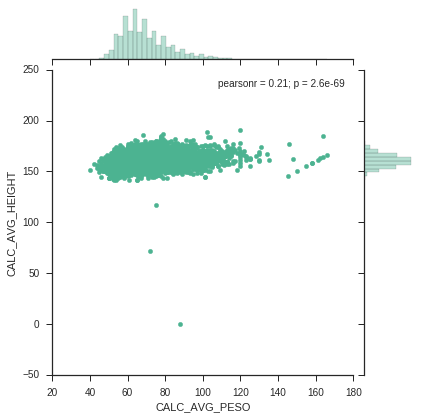

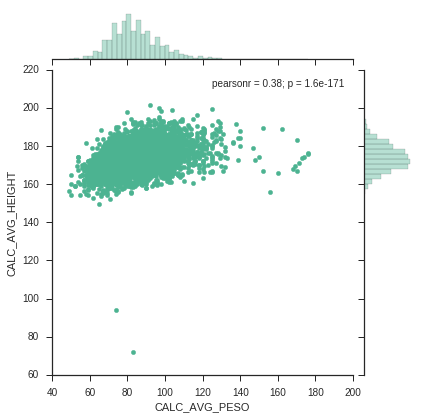

In [5]:
ds = all.copy()

jointplot('CALC_AVG_PESO', 'CALC_AVG_HEIGHT', female(ds))
jointplot('CALC_AVG_PESO', 'CALC_AVG_HEIGHT', male(ds))

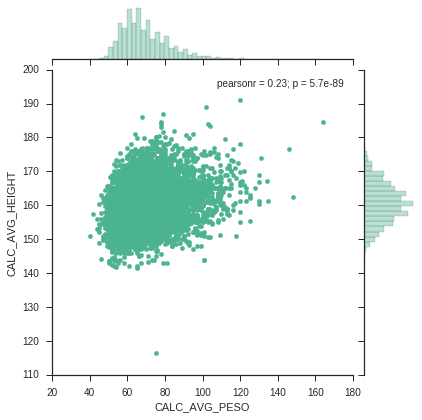

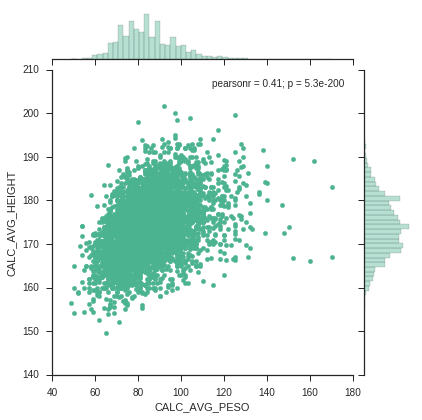

In [6]:
ds = ds[abs(ds['CALC_AVG_HEIGHT'] - ds['CALC_AVG_PESO']) > 2]
ds = ds[ds['CALC_AVG_HEIGHT'] >= 100]
ds = ds.dropna(subset = ['CALC_AVG_HEIGHT', 'CALC_AVG_PESO', 'CALC_AVG_CINTURA_CADERA'])

jointplot('CALC_AVG_PESO', 'CALC_AVG_HEIGHT', female(ds))
jointplot('CALC_AVG_PESO', 'CALC_AVG_HEIGHT', male(ds))

## Height

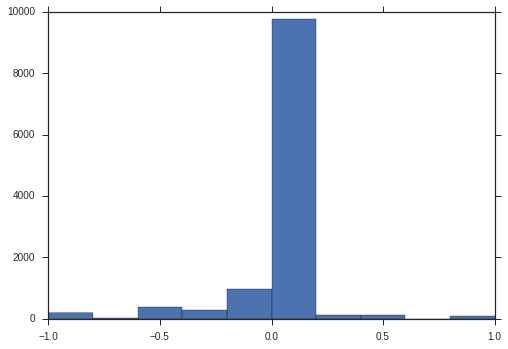

In [7]:
plt.hist(ds['1_ALTURA'] - ds['2_ALTURA'])
plt.show()

## Weight

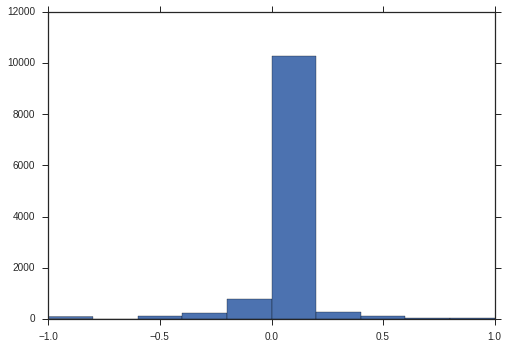

In [8]:
plt.hist(ds['1_Peso'] - ds['2_Peso'])
plt.show()

## Outlier model

In [11]:
from sklearn import svm

def svn_outliers(ds, columns, outcome):
    X = ds[columns]
    # fit the model
    clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
    clf.fit(X)
    ds[outcome] = abs(clf.decision_function(X))
    ds = ds.sort_values([outcome], ascending=False)
    return ds

def plotThreshold(a, b, c, title, xlabel, ylabel):
    fig, ax = plt.subplots()
    colors = plt.cm.coolwarm(c)
    ax.scatter(a, b, c=colors)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.savefig('figures/wh_3.svg')
    plt.show() 
    
def plot_svn(ds, columns, outcome):
    ds = ds.dropna(subset = columns)
    ds = svn_outliers(ds, columns, outcome)
    plotThreshold(
        ds[columns[0]],
        ds[columns[1]],
        ds[outcome],
        'Weight & Height OneClassSVM error',
        'Weight',
        'Height',
    )
    return ds

### Female outliers

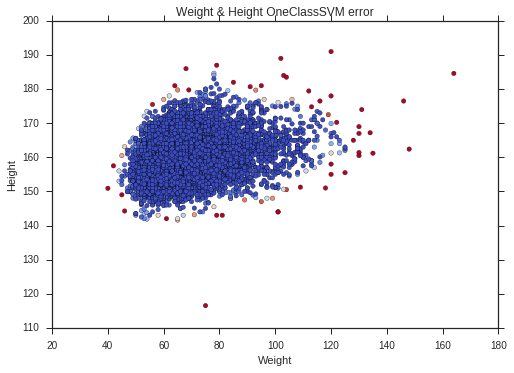

,entity_id,CALC_AVG_PESO,CALC_AVG_HEIGHT,CALC_AVG_CINTURA_CADERA,ERROR_SVN_MEASURES
2014,=E00251430023221,75,116.5,0.888412,2.908128
8435,=E00251439607521,164,184.6,0.771605,2.908128
4005,=E00251514554121,146,176.5,0.949640,2.908128
4073,=E00251432244421,148,162.4,0.911565,2.908128
6676,=E00251529093621,120,191.0,0.939394,2.908128
3091,=E00251427364821,68,186.0,0.861386,2.862295
4916,=E00251513366621,131,174.0,0.786765,2.822978
7303,=E00251533550521,102,189.0,0.816000,2.801674
8000,=E00251531885921,118,151.0,1.006494,2.756990
8293,=E00251527993921,125,155.5,0.828383,2.723921


In [12]:
ds_female = plot_svn(female(ds), ['CALC_AVG_PESO', 'CALC_AVG_HEIGHT', 'CALC_AVG_CINTURA_CADERA'], 'ERROR_SVN_MEASURES')
ds_female[['entity_id', 'CALC_AVG_PESO', 'CALC_AVG_HEIGHT', 'CALC_AVG_CINTURA_CADERA', 'ERROR_SVN_MEASURES']][:10]

### Set female outliers threshold

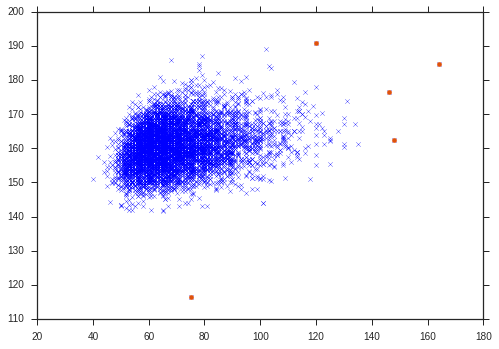

In [13]:
ds_female_outliers = ds_female[ds_female['ERROR_SVN_MEASURES'] > 2.89]
plt.scatter(ds_female['CALC_AVG_PESO'], ds_female['CALC_AVG_HEIGHT'], marker='x')
plt.scatter(ds_female_outliers['CALC_AVG_PESO'], ds_female_outliers['CALC_AVG_HEIGHT'], marker='o', color='#DE510D')
plt.show()

### Male outliers

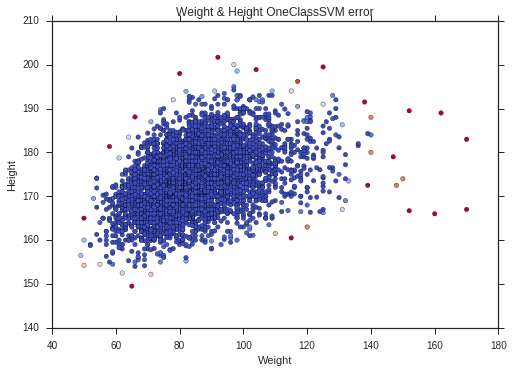

,entity_id,CALC_AVG_PESO,CALC_AVG_HEIGHT,CALC_AVG_CINTURA_CADERA,ERROR_SVN_MEASURES
11997,=E00251615148021,170,167.0,0.828125,1.383545
4910,=E00251510702421,170,183.0,1.037267,1.383541
5209,=E00251529195621,152,189.5,1.078740,1.383540
3703,=E00251514643021,162,189.0,1.044444,1.383496
6932,=E00251531548021,160,166.0,0.981481,1.381965
6370,=E00251532983821,125,199.5,0.918699,1.375653
1814,=E00251510656521,152,166.7,1.082192,1.371796
1738,=E00251417990121,139,172.5,1.032374,1.348855
10748,=E00251619060121,147,179.0,0.985816,1.329538
7293,=E00251524985121,92,201.7,0.790909,1.307908


In [14]:
ds_male = plot_svn(male(ds), ['CALC_AVG_PESO', 'CALC_AVG_HEIGHT', 'CALC_AVG_CINTURA_CADERA'], 'ERROR_SVN_MEASURES')
ds_male[['entity_id', 'CALC_AVG_PESO', 'CALC_AVG_HEIGHT', 'CALC_AVG_CINTURA_CADERA', 'ERROR_SVN_MEASURES']][:10]

### Set male outliers threshold

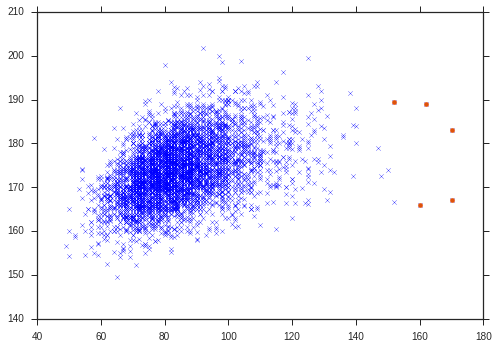

In [15]:
ds_male_outliers = ds_male[ds_male['ERROR_SVN_MEASURES'] > 1.38]
plt.scatter(ds_male['CALC_AVG_PESO'], ds_male['CALC_AVG_HEIGHT'], marker='x')
plt.scatter(ds_male_outliers['CALC_AVG_PESO'], ds_male_outliers['CALC_AVG_HEIGHT'], marker='o', color='#DE510D')
plt.show()

### Remove outliers

In [16]:
outliers = ds_male_outliers.entity_id.append(ds_female_outliers.entity_id)
ds = ds[~ds.entity_id.isin(outliers)]

## BMI

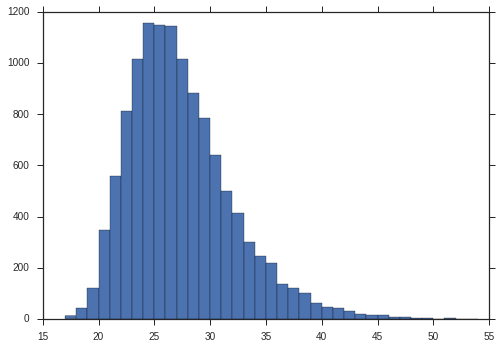

In [18]:
def BMI(weight, height):
    return weight/(height/100)**2

ds['BMI'] = BMI(ds['CALC_AVG_PESO'], ds['CALC_AVG_HEIGHT'])

plt.hist(ds['BMI'], bins=range(int(floor(min(ds['BMI'])) + 1), int(floor(max(ds['BMI'])) + 1)))
plt.show()

## Write errors

In [19]:
outliers = list(set(all.index.values) - set(ds.index.values))
errors = all.iloc[outliers][['entity_id', 'CALC_AVG_HEIGHT', 'CALC_AVG_PESO']]
errors.to_csv('../output/bmi/outliers.csv', index=False)

## Write inferred measures

In [20]:
ds[['entity_id', 'CALC_AVG_HEIGHT', 'CALC_AVG_PESO', 'BMI']].to_csv('../output/measures/data.csv', index=False)